In [1]:
# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
import numpy as np

# Import the keras library
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Layer,Reshape,Conv2DTranspose
from tensorflow.python.client import device_lib
from keras.layers import Multiply, Add
from keras import backend as K

from numpy import random

from matplotlib import pyplot as plt

2.15.0


In [2]:
def plot_label_clusters(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ =encoder.predict(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Preparing the Dataset


In [3]:
(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
print(f"Before reshaping, X_train has a shape of: {x_train.shape}")

x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
print(f"After reshaping, x_train has a shape of: {x_train.shape}")

Before reshaping, X_train has a shape of: (60000, 28, 28)
After reshaping, x_train has a shape of: (60000, 28, 28, 1)


In [8]:
x_train = tf.cast(x_train, tf.float32)
x_train = x_train/255.0

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

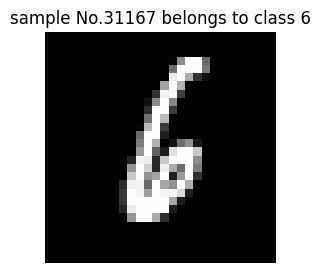

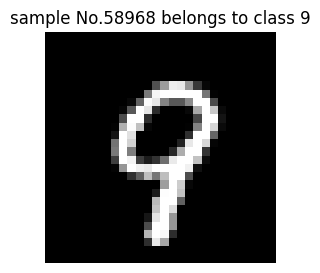

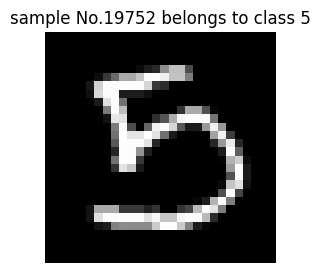

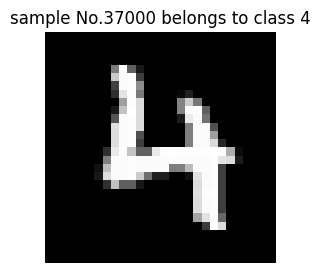

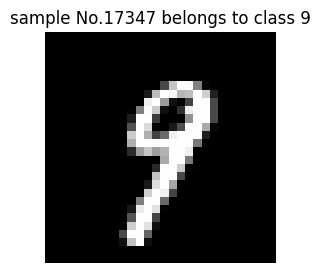

In [10]:
for r in random.randint(0, 59999, size=5, dtype=int):

  plt.figure(figsize=(3, 3));
  plt.imshow(x_train[r,:,:,0], cmap='gray');
  plt.title("sample No.{} belongs to class {}".format(r,y_train[r]));
  plt.axis('off')

## Variational Autoencoder

In a nutshell, the architecture of a VAE is similar to that of a standard Autoencoder such that it consists of an encoder and a decoder, both of which are trained to minimize the reconstruction error between the original data $X$ and the encoded-decoded data $\hat X$.

The training samples $X$ are passed to the encoder to generate samples $\boldsymbol z$, which are mappings of $X$ in the latent space.  The decoder then uses $\boldsymbol z$ to generate the most likely reconstruction $\hat X$.

At this point, a natural question that comes in mind is, how do we use VAEs to generate meaningful content? You might think that if we train a VAE on images, then we can use it to generate new images. However, since it's difficult to regularize what happens to our encoder output in the latent space, we can't be sure that the encoder will organize information in the latent space in a way that the decoder can easily take that information and generates content that seems reasonable.

Hence, in order to be able to use the VAE for meaningful generative purposes, we need to introduce some regularization into the latent space. As shown in the diagram below, **instead of mapping the input to a single point in the latent space, we encode it as a normal distribution by returning the mean and standard deviation of the distribution**. By doing so, the decoder would be able to use the regularized information to construct new content.

In the following sections, we will build a VAE by following the architecture in the illustrative diagram below.


## Encoder Part

We build the encoder part by breaking it up into three smaller parts.

The **first part** of the encoder consists of several fully connected layers, as shown in the picture below, which encodes the high-dimensional input; For our implementation, we will use two **convolution layers** since we want the model to learn the image data using convolutions.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/encoder.png" width="30%" alt="computer components"/></center>


In [14]:
encoder_input = keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_input)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
encoder_output = Dense(16, activation='relu')(x)

The **second part** of the encoder represents a normal distribution over the latent space that takes the `encoder_output` and gives you the probability of it belonging to the distribution.

The mean and standard deviation of the normal distribution will be learned and then used to calculate the log-likelihood for optimization purposes.


 <center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/mean_var.png" width="400" alt="computer components"  />
<center>


To implement the second part, we create **two Dense layers** in parallel for the model to learn the **mean** and **log variance** respectively; We want the model to learn the log variance instead of the variance because it brings more stability and ease of training. The detailed reason is as follows:

*   By definition, $\sigma$ is a non-negative real number. To enforce this, we would need to use the ReLU activation to obtain such a value, but the gradient is not well defined around zero.
*   Besides, since we typically apply normalization methods in model training, the data values range from 0 to 1, which means the standard deviation of those values is also very small. This adds a burden to the optimization process and causes numerical instabilities as the gradients flowing in the backpropagation will contain floating points.

Note that we can convert the log variance to the standard deviation using the exponential function. Here is the code for building the second part:


In [15]:
latent_dim = 2

# Dense layer to learn the mean
mean = Dense(latent_dim, name="mean")(encoder_output)
# Dense layer to learn the log variance
log_var = Dense(latent_dim, name="z_log_var")(encoder_output)

# sigmia is calculated from log variance
sigma = tf.exp(0.5 * log_var)

In [16]:
# random normal noise
epsilon = K.random_normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

In [17]:
#z = mean + sigma * epsilon

z_eps = Multiply()([sigma, epsilon])
z = Add()([mean, z_eps])

In [18]:
encoder = Model(encoder_input, outputs = [mean, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 32)           320       ['input_4[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_4[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 3136)                 0         ['conv2d_5[0][0]']            
                                                                                            

## Decoder Part

The decoder part of a VAE is the same as that of a regular Autoencoder. To upsample the output from the encoder, we can use the Keras Sequential model API to group a stack of Dense layers and Transpose Convolution layers together.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/decoder.png" width="400" alt="computer components"  />
<center>


In [20]:
latent_dim = 2
decoder = Sequential()

decoder.add(keras.Input(shape=(latent_dim,)))
decoder.add(Dense(7 * 7 * 64, activation='relu'))
decoder.add(Reshape((7, 7, 64)))
decoder.add(Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'))
decoder.add(Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'))
decoder.add(Conv2DTranspose(1, 3, activation='relu', strides=2))
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 57, 57, 1)         289       
 Transpose)                                                      
                                                      

# Loss Function

In [21]:
# make loss function

#reconstruction_loss
def reconstruction_loss(y, y_hat):
    return tf.reduce_mean(tf.square(y - y_hat))


#Kullback–Leibler divergence encoder loss
def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    return loss

# add two losses
def vae_loss(y_true, y_hat, mu, log_var):
    return reconstruction_loss(y_true, y_hat) + (1 / (64*64)) * kl_loss(mean, log_var)


## Putting it all Together

In [22]:
# encoder returns mean and log variance of the normal distribution,
# and a sample point z
mean, log_var, z = encoder(encoder_input)

# decoder decodes the sample z
reconstructed = decoder(z)

model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mean, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  69076     ['input_4[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 sequential_1 (Sequential)   (None, 57, 57, 1)            65089     ['encoder[0][2]']             
                                                                                                

## Training the VAE

We now train the model. After each epoch, we input random noise <code>z</code> into the decoder. We will see for each epoch, the decoder output will look more and more like a digit.

We also output the values for the latent space z for all the different digits in our dataset, color coded according to class. We see that for each iteration, the samples appeared more clustered.


Samples generated by decoder after 0 epoch(s): 
1/1 [==============================] - 0s 21ms/step


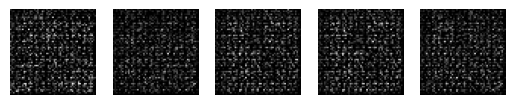

2D latent representations of the training data produced by encoder after 0 epoch(s): 
1875/1875 [==============================] - 5s 3ms/step


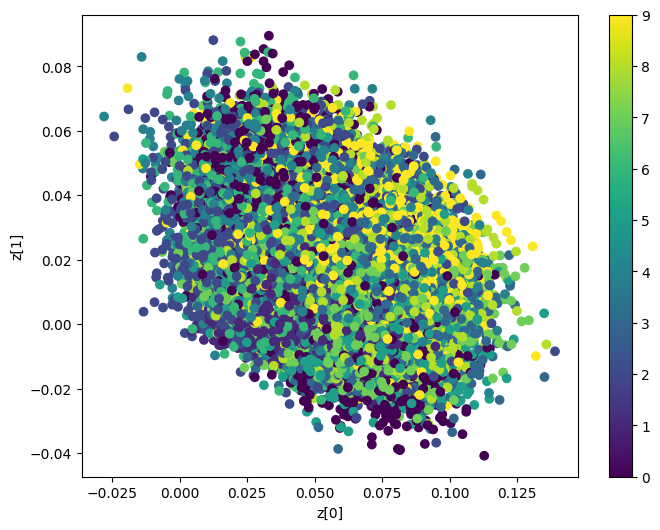

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [324,28,28,1] vs. [324,57,57,1] [Op:Sub] name: 

In [30]:
mse_losses = []
kl_losses = []
batch_size = 324

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
epochs = 5

for epoch in range(epochs):

    print(f"Samples generated by decoder after {epoch} epoch(s): ")

    # Random noise
    z = tf.random.normal(shape=(5, latent_dim,))

    # Input random noise into the decoder
    xhat = decoder.predict(z)

    # Plot the decoder output
    plt.figure()
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(xhat[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.show()

    print(f"2D latent representations of the training data produced by encoder after {epoch} epoch(s): ")
    plot_label_clusters(encoder, x_train, y_train)

    # Training steps
    for (step, training_batch) in enumerate(dataset.batch(batch_size)):
        with tf.GradientTape() as tape:

            # Model output
            reconstructed = model(training_batch)

            # Calculate reconstruction loss (assuming appropriate reshaping)
            mse_loss = reconstruction_loss(training_batch, reconstructed)

            # Calculate KL divergence
            kl = sum(model.losses)

            kl_losses.append(kl.numpy())
            mse_losses.append(mse_loss.numpy())

            # Total loss
            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))


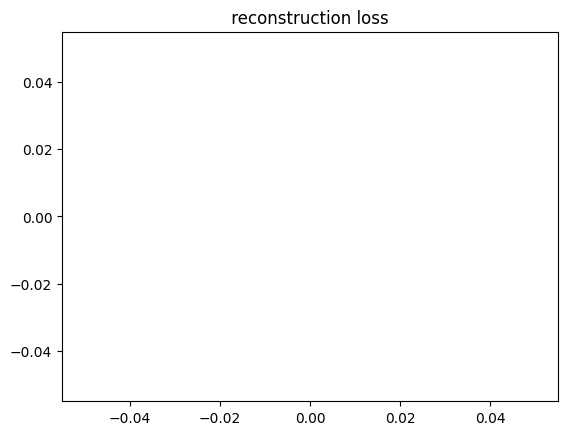

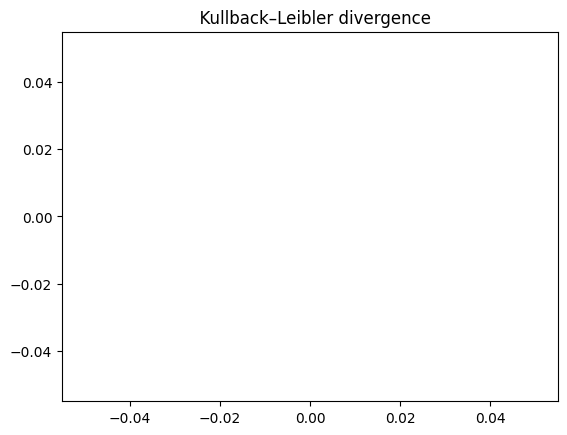

In [25]:
plt.plot(mse_losses)
plt.title(" reconstruction loss ")
plt.show()
plt.plot(kl_losses)
plt.title("  Kullback–Leibler divergence")
plt.show()

1/1 [==============================] - 0s 30ms/step


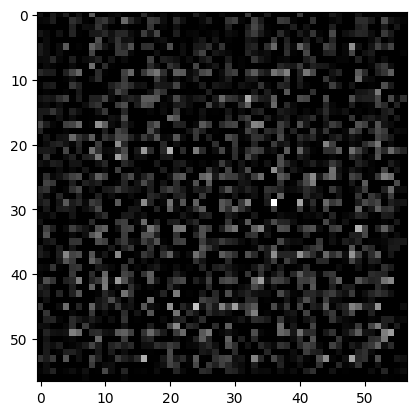

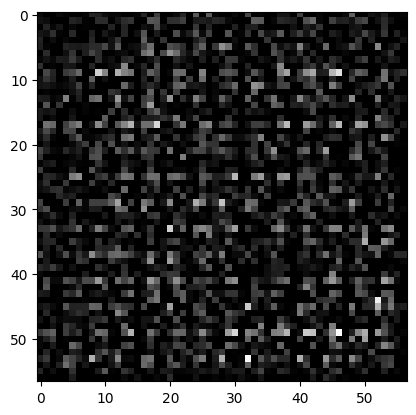

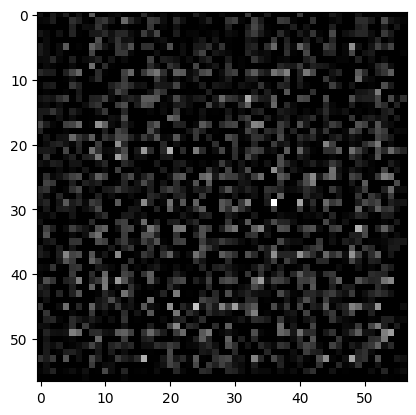

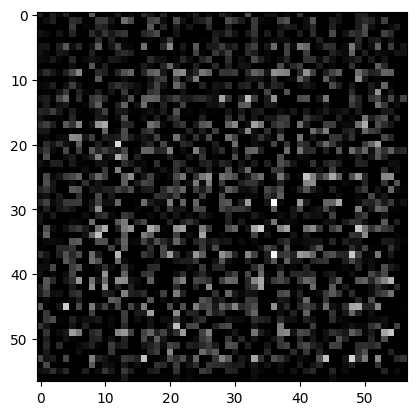

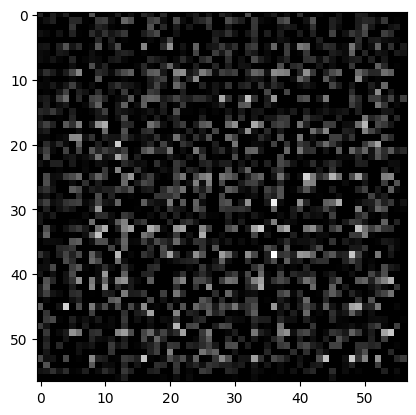

In [26]:
xhat = decoder.predict(z)

for i in range(5):
    plt.imshow(xhat[i,:,:,0],cmap="gray")
    plt.show()

1875/1875 [==============================] - 5s 3ms/step


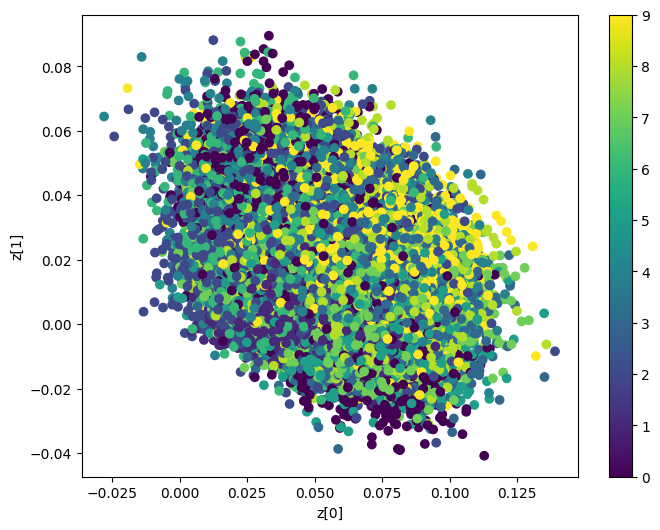

In [28]:
plot_label_clusters(encoder, x_train, y_train)